## Project 1B

In [325]:
# Initial imports
import os
import requests
from pathlib import Path
import json
import numpy as np
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import altair as alt
from MCForecastTools import MCSimulation

%matplotlib inline

In [326]:
# Load .env enviroment variables
load_dotenv()

True

In [327]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url="https://paper-api.alpaca.markets",
    api_version="v2")

In [328]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-31", tz="America/New_York").isoformat()
start_day = pd.Timestamp("2016-03-31", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["SCHZ", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SCHZ and SPY
ticker_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_day,
    end = today,
    limit = 1000
).df

# Preview DataFrame
ticker_data.head()

SCHZ                                        SPY  \
                            open     high      low  close    volume    open   
time                                                                          
2017-04-10 00:00:00-04:00  51.80  51.8400  51.7600  51.81  459968.0     NaN   
2017-04-11 00:00:00-04:00  51.90  51.9653  51.8470  51.94  407094.0  234.87   
2017-04-12 00:00:00-04:00  52.00  52.0800  51.9500  52.05  443459.0  234.74   
2017-04-13 00:00:00-04:00  52.14  52.1400  52.0267  52.11  557840.0  233.63   
2017-04-17 00:00:00-04:00  52.19  52.2000  52.0801  52.11  443970.0  233.11   

                                                               
                             high     low   close      volume  
time                                                           
2017-04-10 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-11 00:00:00-04:00  235.18  233.34  235.04  63951745.0  
2017-04-12 00:00:00-04:00  234.96  233.77  234.10  55338215.0  
2017-04-13 00:00:00-04:00  234.49  232.54  232.54  63216959.0  
2017-04-17 00:00:00-04:00  234.57  232.88  234.57  46820072.0

In [329]:
#Create SCHZ and SPY Dataframe
df_closingprice = pd.DataFrame()
df_closingprice["SCHZ"]= ticker_data["SCHZ"]["close"]
df_closingprice["SPY"]= ticker_data["SPY"]["close"]
df_closingprice.index=df_closingprice.index.date
df_closingprice.head()

,SCHZ,SPY
2017-04-10,51.81,NaN
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57


In [330]:
#Data Cleaning
df_closingprice.isnull().sum()

SCHZ    1
SPY     1
dtype: int64

In [331]:
df_closingprice = df_closingprice.dropna().copy()

In [332]:
df_closingprice.isnull().sum()

SCHZ    0
SPY     0
dtype: int64

In [333]:
df_closingprice.count()

SCHZ    999
SPY     999
dtype: int64

In [334]:
df_closingprice.head()

,SCHZ,SPY
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57
2017-04-18,52.29,233.86


In [335]:
#Assigning weights to Traditional Income (ti) portfolio
ti_schz_percent = 0.80
ti_spy_percent = 0.20

traditional_returns = df_closingprice.pct_change()
traditional_returns = traditional_returns.dropna().copy()
weights_ti = [ti_schz_percent, ti_spy_percent]
ti_weighted = traditional_returns.dot(weights_ti)
ti_weighted.head()

2017-04-12    0.000894
2017-04-13   -0.000411
2017-04-17    0.001746
2017-04-18    0.002158
2017-04-19   -0.001404
dtype: float64

<AxesSubplot:title={'center':'Income Portfolio Cumulative Returns'}>

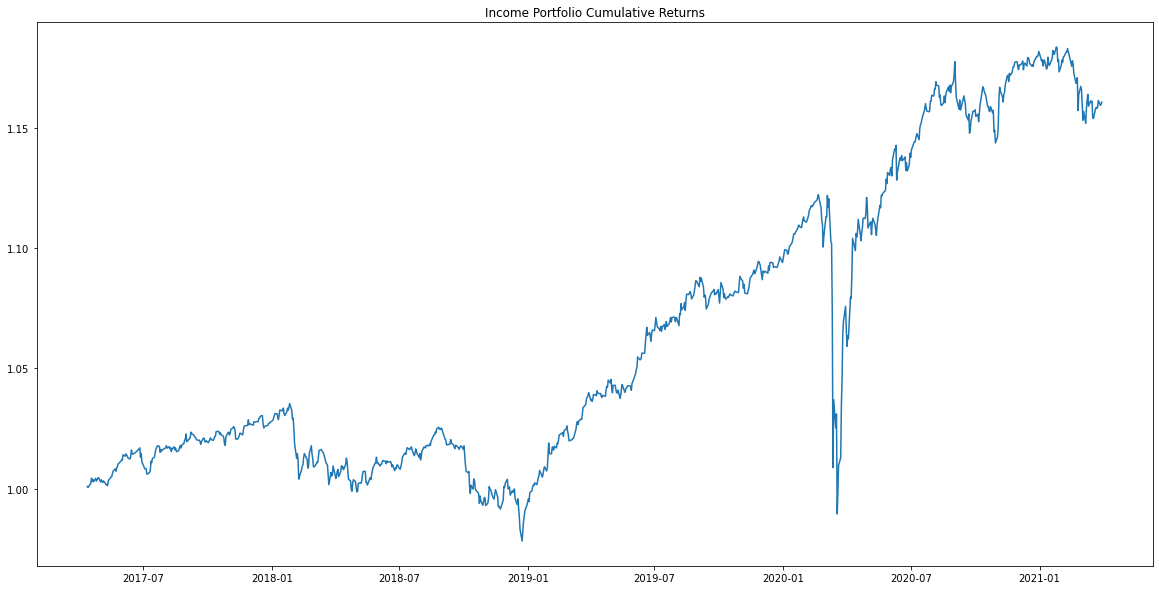

In [336]:
#Calculate and plot combined returns
ti_cumulative_returns = (1 + ti_weighted).cumprod()
ti_cumulative_returns.plot(figsize=(20,10), title = "Income Portfolio Cumulative Returns")

In [337]:
#Retrieve Crypto (BTC) Prices and create Dataframe
btc_prices_csv = Path("resources/btc_usd_5_year_historical.csv")
btc_prices = pd.read_csv(
    btc_prices_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_prices = btc_prices.sort_index()
btc_prices.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-30,57750.132813,59447.222656,57251.550781,58917.691406,58917.691406,5.441412e+10
2021-03-31,58930.277344,59930.027344,57726.417969,58918.832031,58918.832031,6.552083e+10
2021-04-01,58926.562500,59586.070313,58505.277344,59095.808594,59095.808594,6.166916e+10
2021-04-02,59098.878906,60267.187500,58869.281250,59384.312500,59384.312500,5.872786e+10
2021-04-03,59349.503906,60056.664063,59296.511719,59426.746094,59426.746094,5.388229e+10


In [338]:
#Isolate Crypto close price
btc_closingprice = pd.DataFrame()
btc_closingprice = btc_prices["Close"]
btc_closingprice.index= btc_closingprice.index.date
btc_closingprice.head()

2016-04-03    420.903992
2016-04-04    421.444000
2016-04-05    424.029999
2016-04-06    423.412994
2016-04-07    422.744995
Name: Close, dtype: float64

In [339]:
#Combine Traditional Income portfolio with Crypto to create Hybrid Portfolio
hybrid_close = pd.concat([df_closingprice, btc_closingprice], axis="columns", join="inner")
hybrid_close = hybrid_close.rename(columns={"Close": "Crypto"})
hybrid_close.head()

,SCHZ,SPY,Crypto
2017-04-11,51.94,235.04,1205.010010
2017-04-12,52.05,234.10,1200.369995
2017-04-13,52.11,232.54,1169.280029
2017-04-17,52.11,234.57,1193.910034
2017-04-18,52.29,233.86,1211.670044


In [340]:
#Calculating daily returns on Hybrid Portfolio
hybrid_returns = hybrid_close.pct_change()
hybrid_returns = hybrid_returns.dropna().copy()
hybrid_returns.head()

,SCHZ,SPY,Crypto
2017-04-12,0.002118,-0.003999,-0.003851
2017-04-13,0.001153,-0.006664,-0.025900
2017-04-17,0.000000,0.008730,0.021064
2017-04-18,0.003454,-0.003027,0.014876
2017-04-19,-0.001339,-0.001668,-0.001139


In [341]:
# Adding 2% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hi_btc_percent = 0.02
hi_schz_percent = ti_schz_percent - (ti_schz_percent * hi_btc_percent)
hi_spy_percent = ti_spy_percent - (ti_spy_percent * hi_btc_percent)

#Assigning weights to Hybrid Income (hi) Portfolio
weights_hi = [hi_schz_percent, hi_spy_percent, hi_btc_percent]
hi_weighted = hybrid_returns.dot(weights_hi)
hi_weighted.head()

2017-04-12    0.000799
2017-04-13   -0.000920
2017-04-17    0.002132
2017-04-18    0.002412
2017-04-19   -0.001399
dtype: float64

In [342]:
print(hi_schz_percent)
print(hi_spy_percent)
print(hi_btc_percent)

0.784
0.196
0.02


<AxesSubplot:title={'center':'Hybrid Income Portfolio Cumulative Returns'}>

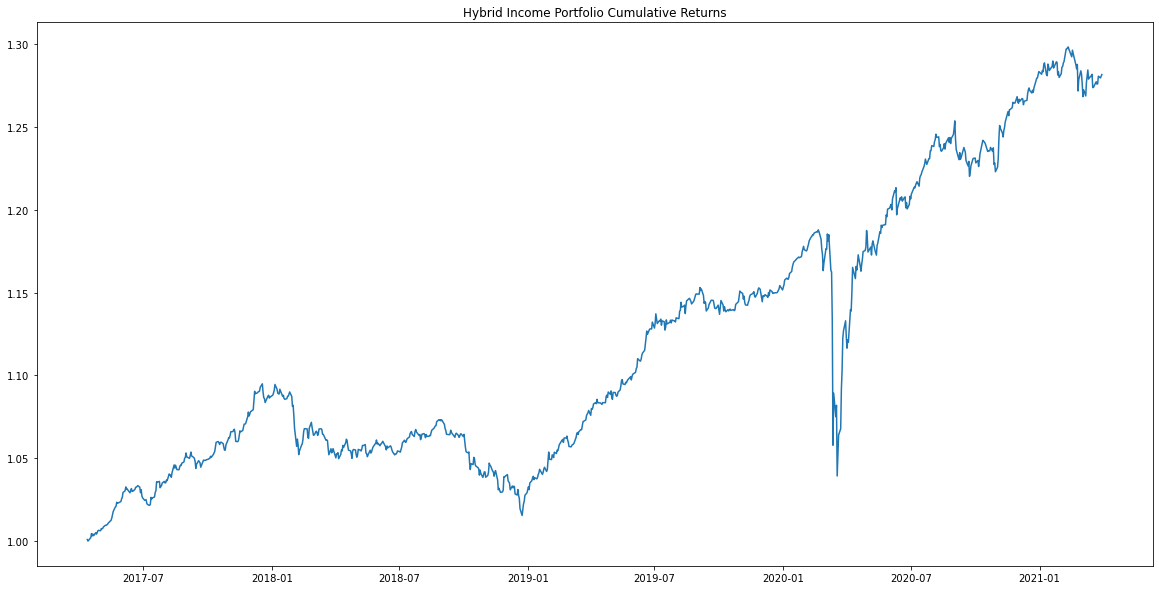

In [343]:
#Calculate and plot Hybrid Income Portfolio returns
hi_cumulative_returns = (1 + hi_weighted).cumprod()
hi_cumulative_returns.plot(figsize=(20,10), title = "Hybrid Income Portfolio Cumulative Returns")

In [344]:
#Combined Traditional Income and Hybrid Income dataframes
thi_cumulative_returns = pd.concat([ti_cumulative_returns, hi_cumulative_returns], axis="columns", join="inner")
columns = ["Traditional Income", "Hybrid Income"]
thi_cumulative_returns.columns = columns
thi_cumulative_returns.tail()

,Traditional Income,Hybrid Income
2021-03-25,1.158730,1.276071
2021-03-26,1.161466,1.280719
2021-03-29,1.159375,1.279673
2021-03-30,1.159908,1.280767
2021-03-31,1.160778,1.281708


<AxesSubplot:title={'center':'Traditional vs. Hybrid Income Portfolio Cumulative Returns'}>

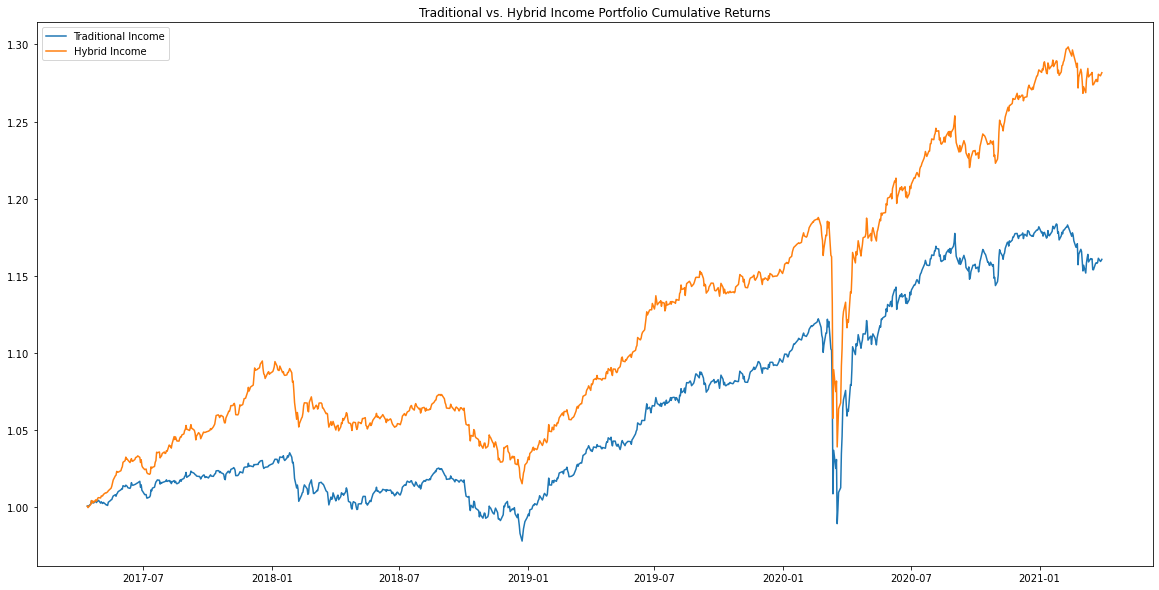

In [345]:
#Plot combined Income Dataframes
thi_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Income Portfolio Cumulative Returns")

In [346]:
#Combine Traditional and Hybrid Income Dataframes
thi_returns = pd.concat([ti_weighted, hi_weighted], axis="columns", join="inner")
columns = ["Traditional Income", "Hybrid Income"]
thi_returns.columns = columns
thi_returns.tail()

,Traditional Income,Hybrid Income
2021-03-25,0.000487,0.000072
2021-03-26,0.002361,0.003642
2021-03-29,-0.001801,-0.000817
2021-03-30,0.000460,0.000855
2021-03-31,0.000750,0.000735


In [347]:
#Calculate Sharpe Ratios on Traditional and Hybrid Income Portfolios
thi_sharpe_ratios = (thi_returns.mean() * 252) / (thi_returns.std() * np.sqrt(252))
thi_sharpe_ratios

Traditional Income    0.665134
Hybrid Income         1.020745
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

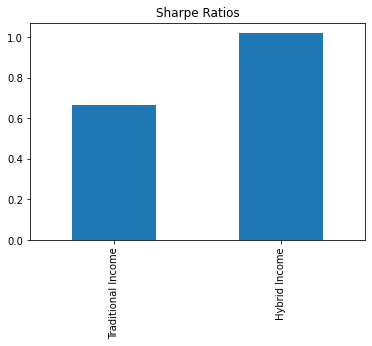

In [348]:
# Visualize the sharpe ratios as a bar plot
thi_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

In [349]:
print(f"For the Traditional Income Portfolio, the Sharpe Ratio is {thi_sharpe_ratios[0]:0.2f}.")
print(f"For the Hybrid Income Portfolio, the Sharpe Ratio is {thi_sharpe_ratios[1]:0.2f}.")

For the Traditional Income Portfolio, the Sharpe Ratio is 0.67.
For the Hybrid Income Portfolio, the Sharpe Ratio is 1.02.


### Start of Balanced Portfolio Section

In [350]:
#Assigning weights to Traditional Balanced (tb) portfolio
tb_schz_percent = 0.5
tb_spy_percent = 0.5
weights_tb = [tb_schz_percent, tb_spy_percent]
tb_weighted = traditional_returns.dot(weights_tb)
tb_weighted.head()

2017-04-12   -0.000941
2017-04-13   -0.002756
2017-04-17    0.004365
2017-04-18    0.000214
2017-04-19   -0.001503
dtype: float64

<AxesSubplot:title={'center':'Traditional Balanced Portfolio Cumulative Returns'}>

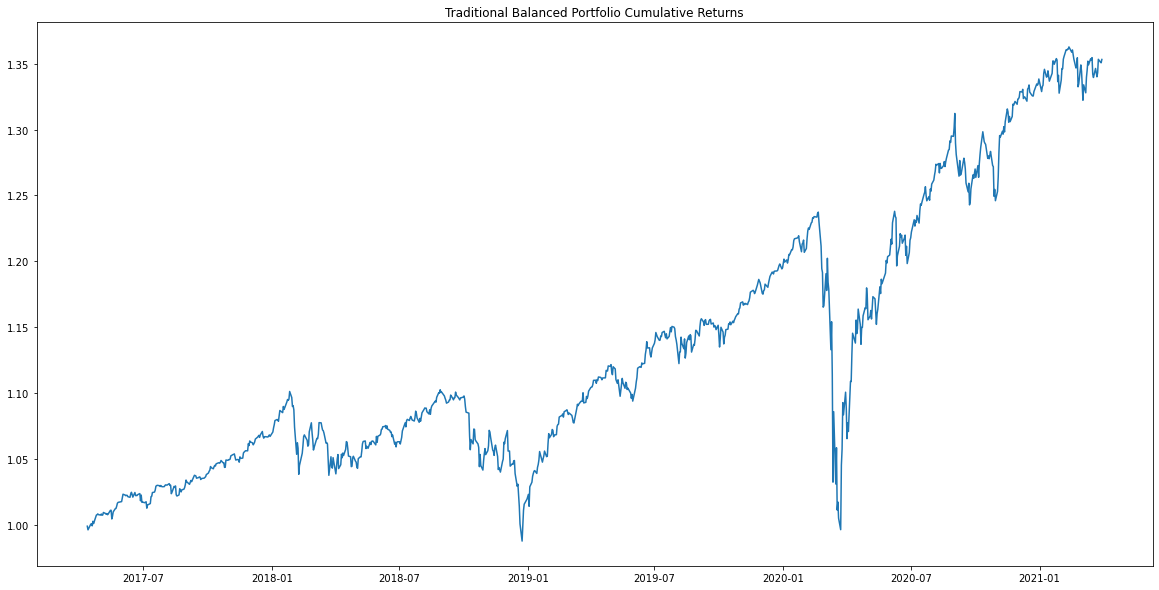

In [351]:
#Calculate and plot Traditional Balanced Portfolio returns
tb_cumulative_returns = (1 + tb_weighted).cumprod()
tb_cumulative_returns.plot(figsize=(20,10), title = "Traditional Balanced Portfolio Cumulative Returns")

In [352]:
# Adding 4% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hb_btc_percent = 0.04
hb_schz_percent = hi_schz_percent - (hi_schz_percent * hb_btc_percent)
hb_spy_percent = hi_spy_percent - (hi_spy_percent * hb_btc_percent)
weights_hb = [hb_schz_percent, hb_spy_percent, hb_btc_percent]
hb_weighted = hybrid_returns.dot(weights_hb)
hb_weighted.head()

2017-04-12    0.000687
2017-04-13   -0.001422
2017-04-17    0.002485
2017-04-18    0.002625
2017-04-19   -0.001367
dtype: float64

<AxesSubplot:title={'center':'Hybrid Balanced Cumulative Portfolio Returns'}>

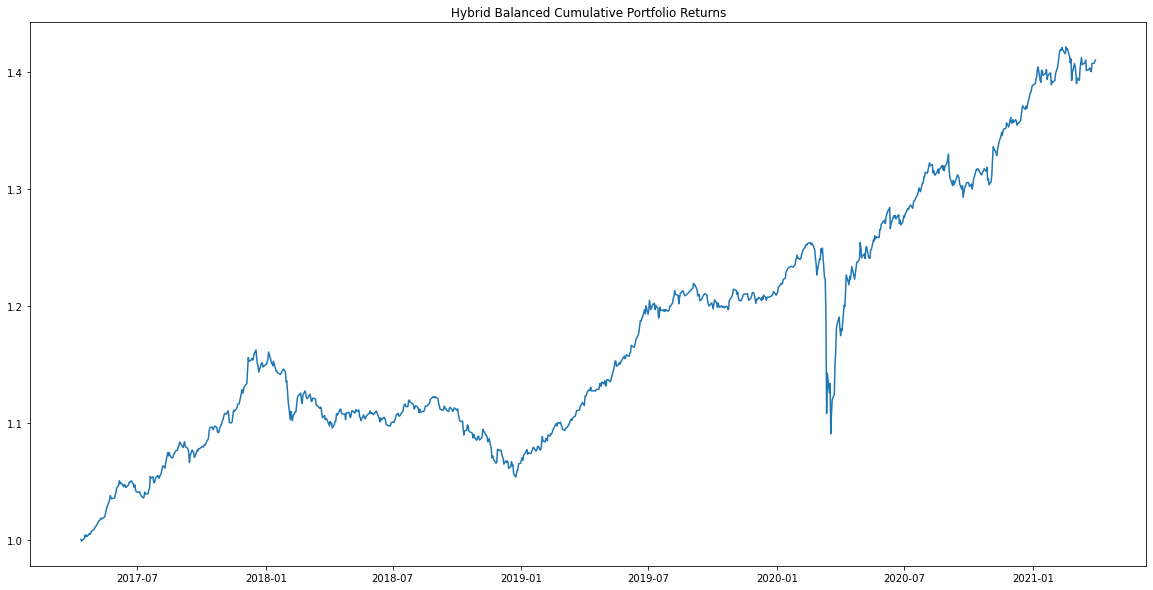

In [353]:
#Calculate and plot Hybrid Balanced Portfolio returns
hb_cumulative_returns = (1 + hb_weighted).cumprod()
hb_cumulative_returns.plot(figsize=(20,10), title = "Hybrid Balanced Cumulative Portfolio Returns")

In [354]:
#Combined Traditional and Hybrid Balanced Dataframes
thb_cumulative_returns = pd.concat([tb_cumulative_returns, hb_cumulative_returns], axis="columns", join="inner")
columns = ["Traditional Balanced", "Hybrid Balanced"]
thb_cumulative_returns.columns = columns
thb_cumulative_returns.tail()

,Traditional Balanced,Hybrid Balanced
2021-03-25,1.343162,1.400155
2021-03-26,1.353327,1.406984
2021-03-29,1.351182,1.407268
2021-03-30,1.350667,1.409015
2021-03-31,1.353199,1.410010


<AxesSubplot:title={'center':'Traditional vs. Hybrid Balanced Portfolio Cumulative Returns'}>

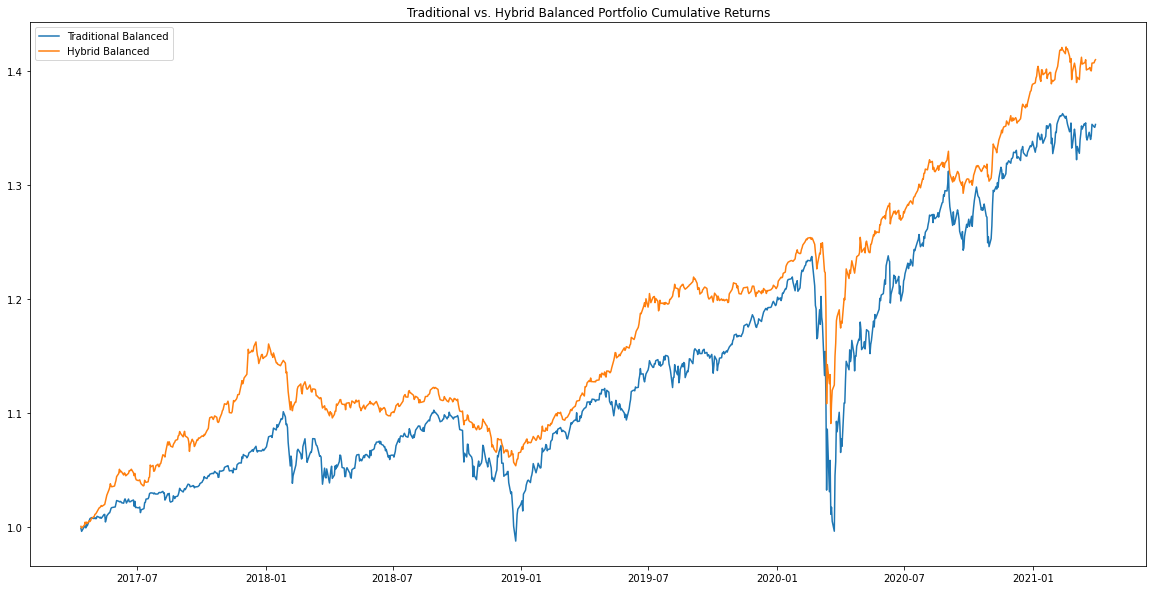

In [355]:
#Plot combined Balanced Dataframes
thb_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Balanced Portfolio Cumulative Returns")

### Sharpe Ratios for Balanced Portfolio

In [356]:
#Combine Traditional and Hybrid Income Weighted Daily Returns Dataframes
thb_returns = pd.concat([tb_weighted, hb_weighted], axis="columns", join="inner")
columns = ["Traditional Balanced", "Hybrid Balanced"]
thb_returns.columns = columns
thb_returns.head()

,Traditional Balanced,Hybrid Balanced
2017-04-12,-0.000941,0.000687
2017-04-13,-0.002756,-0.001422
2017-04-17,0.004365,0.002485
2017-04-18,0.000214,0.002625
2017-04-19,-0.001503,-0.001367


In [357]:
#Calculate Sharpe Ratios on Traditional and Hybrid Balanced Portfolios
thb_sharpe_ratios = ((thb_returns.mean()) * 252) / (thb_returns.std() * np.sqrt(252))
thb_sharpe_ratios

Traditional Balanced    0.761784
Hybrid Balanced         1.277886
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

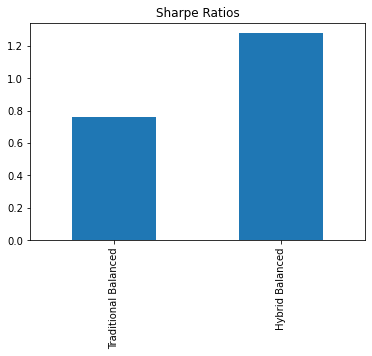

In [358]:
thb_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

In [359]:
print(f"For the Traditional Balanced Portfolio, the Sharpe Ratio is {thb_sharpe_ratios[0]:0.2f}.")
print(f"For the Hybrid Balanced Portfolio, the Sharpe Ratio is {thb_sharpe_ratios[1]:0.2f}.")

For the Traditional Balanced Portfolio, the Sharpe Ratio is 0.76.
For the Hybrid Balanced Portfolio, the Sharpe Ratio is 1.28.


### Growth Section Below

In [360]:
#Assigning weights to Traditional Growth (tg) portfolio
tg_schz_percent = 0.20
tg_spy_percent = 0.80

weights_tg = [tg_schz_percent, tg_spy_percent]
tg_weighted = traditional_returns.dot(weights_tg)
tg_weighted.head()

2017-04-12   -0.002776
2017-04-13   -0.005101
2017-04-17    0.006984
2017-04-18   -0.001731
2017-04-19   -0.001602
dtype: float64

<AxesSubplot:title={'center':'Traditional Growth Portfolio Cumulative Returns'}>

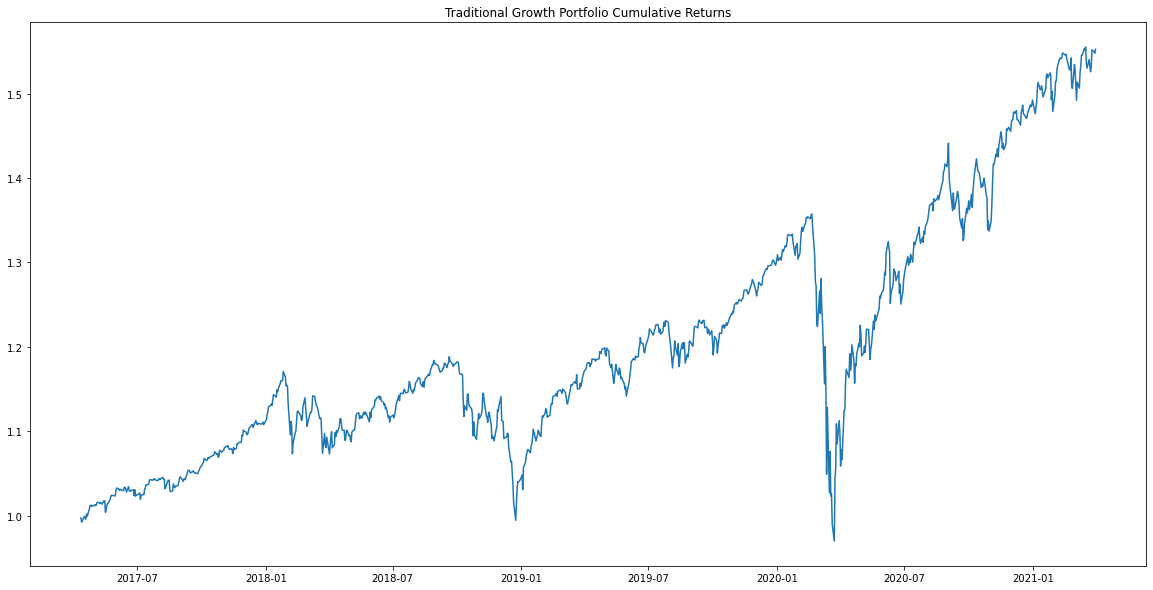

In [361]:
#Calculate and plot combined returns
tg_cumulative_returns = (1 + tg_weighted).cumprod()
tg_cumulative_returns.plot(figsize=(20,10), title = "Traditional Growth Portfolio Cumulative Returns")

In [362]:
# Adding 6% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hg_btc_percent = 0.06
hg_schz_percent = tg_schz_percent - (tg_schz_percent * hg_btc_percent)
hg_spy_percent = tg_spy_percent - (tg_spy_percent * hg_btc_percent)


#Assigning weights to Hybrid Growth (hg) Portfolio
weights_hg = [hg_schz_percent, hg_spy_percent, hg_btc_percent]
hg_weighted = hybrid_returns.dot(weights_hg)
hg_weighted.head()

2017-04-12   -0.002840
2017-04-13   -0.006348
2017-04-17    0.007829
2017-04-18   -0.000734
2017-04-19   -0.001574
dtype: float64

<AxesSubplot:title={'center':'Hybrid Growth Portfolio Cumulative Returns'}>

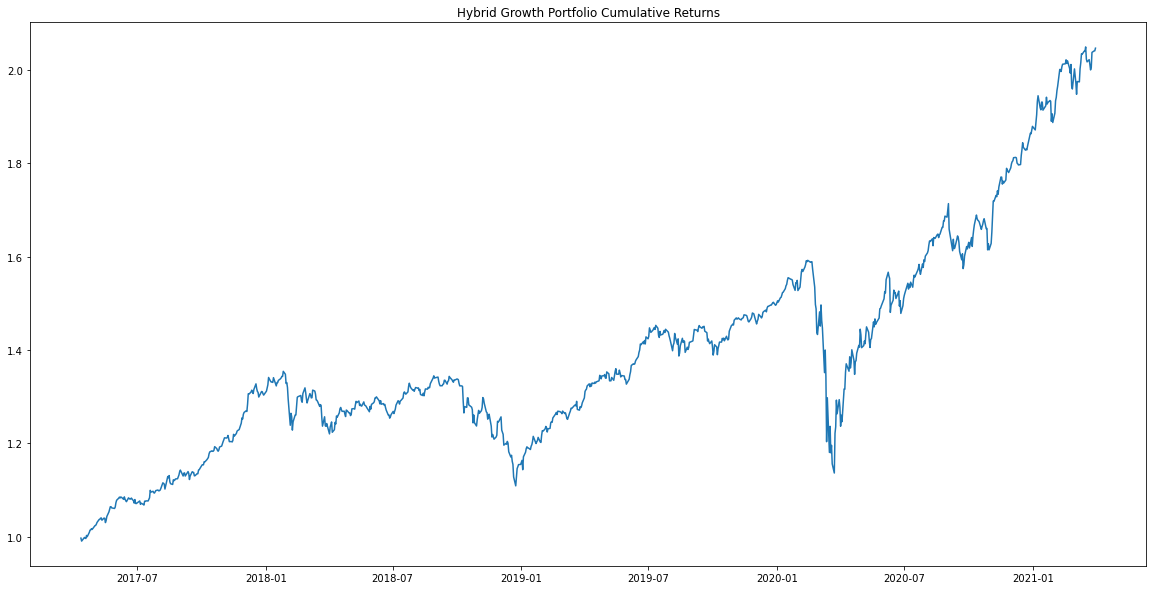

In [363]:
#Calculate and plot Hybrid Growth Portfolio returns
hg_cumulative_returns = (1 + hg_weighted).cumprod()
hg_cumulative_returns.plot(figsize=(20,10), title = "Hybrid Growth Portfolio Cumulative Returns")

In [364]:
#Combined Traditional Income and Hybrid Income dataframes
thg_cumulative_returns = pd.concat([tg_cumulative_returns, hg_cumulative_returns], axis="columns", join="inner")
columns = ["Traditional Growth", "Hybrid Growth"]
thg_cumulative_returns.columns = columns
thg_cumulative_returns.tail()

,Traditional Growth,Hybrid Growth
2021-03-25,1.532168,2.004965
2021-03-26,1.551741,2.037029
2021-03-29,1.549617,2.040200
2021-03-30,1.547723,2.040331
2021-03-31,1.552365,2.046086


<AxesSubplot:title={'center':'Traditional vs. Hybrid Growth Portfolio Cumulative Returns'}>

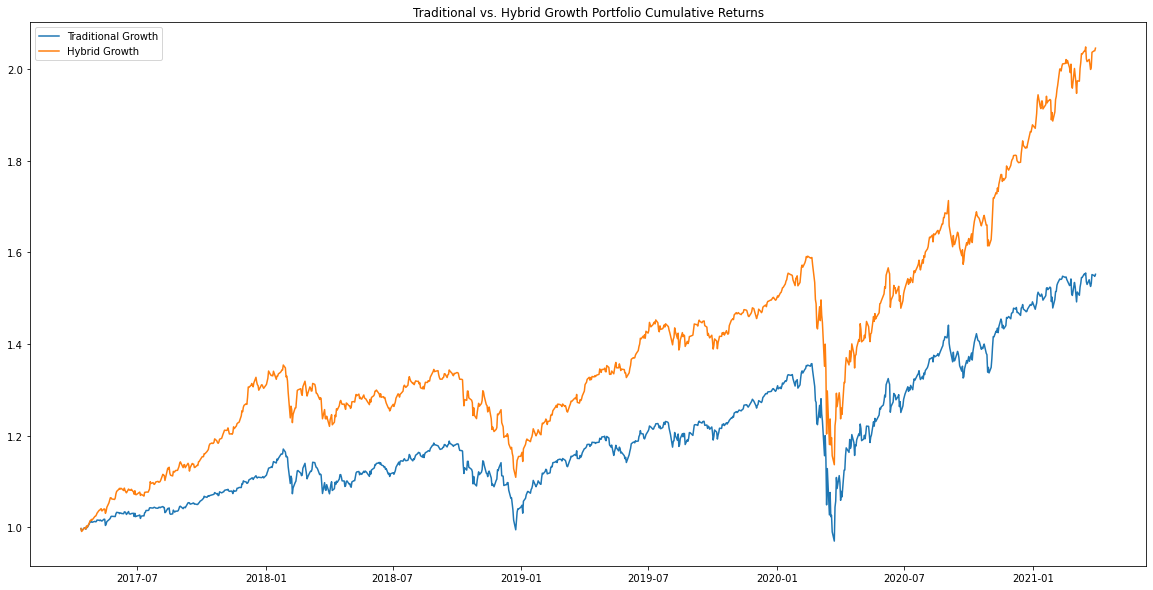

In [365]:
#Plot combined Income Dataframes
thg_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Growth Portfolio Cumulative Returns")

In [366]:
#Combine Traditional and Hybrid Income Weighted Daily Returns Dataframes
thg_returns = pd.concat([tg_weighted, hg_weighted], axis="columns", join="inner")
columns = ["Traditional Growth", "Hybrid Growth"]
thg_returns.columns = columns
thg_returns.head()

,Traditional Growth,Hybrid Growth
2017-04-12,-0.002776,-0.002840
2017-04-13,-0.005101,-0.006348
2017-04-17,0.006984,0.007829
2017-04-18,-0.001731,-0.000734
2017-04-19,-0.001602,-0.001574


In [367]:
#Calculate Sharpe Ratios on Traditional and Hybrid Income Portfolios
thg_sharpe_ratios = ((thg_returns.mean()) * 252) / (thg_returns.std() * np.sqrt(252))
thg_sharpe_ratios

Traditional Growth    0.749422
Hybrid Growth         1.136665
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

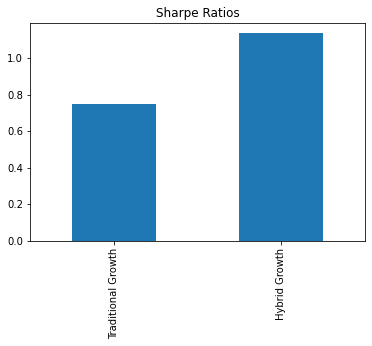

In [368]:
# Visualize the sharpe ratios as a bar plot
thg_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Need to add summary statements

In [369]:
print(f"For the Traditional Growth Portfolio, the Sharpe Ratio is {thg_sharpe_ratios[0]:0.2f}.")
print(f"For the Hybrid Growth Portfolio, the Sharpe Ratio is {thg_sharpe_ratios[1]:0.2f}.")

For the Traditional Growth Portfolio, the Sharpe Ratio is 0.75.
For the Hybrid Growth Portfolio, the Sharpe Ratio is 1.14.


# Combined Sharpe Ratios

In [370]:
#Concat all Sharpe Ratios
all_daily_returns = pd.concat([thi_returns, thb_returns, thg_returns], axis="columns", join="inner")
all_daily_returns

,Traditional Income,Hybrid Income,Traditional Balanced,Hybrid Balanced,Traditional Growth,Hybrid Growth
2017-04-12,0.000894,0.000799,-0.000941,0.000687,-0.002776,-0.002840
2017-04-13,-0.000411,-0.000920,-0.002756,-0.001422,-0.005101,-0.006348
2017-04-17,0.001746,0.002132,0.004365,0.002485,0.006984,0.007829
2017-04-18,0.002158,0.002412,0.000214,0.002625,-0.001731,-0.000734
2017-04-19,-0.001404,-0.001399,-0.001503,-0.001367,-0.001602,-0.001574
...,...,...,...,...,...,...
2021-03-25,0.000487,0.000072,0.002327,-0.000353,0.004166,0.002700
2021-03-26,0.002361,0.003642,0.007568,0.004877,0.012775,0.015992
2021-03-29,-0.001801,-0.000817,-0.001585,0.000202,-0.001369,0.001557
2021-03-30,0.000460,0.000855,-0.000381,0.001241,-0.001222,0.000064


In [371]:
# Annualized Sharpe Ratios
all_sharpe_ratios = (all_daily_returns.mean() * 252) / (all_daily_returns.std() * np.sqrt(252))
all_sharpe_ratios

Traditional Income      0.665134
Hybrid Income           1.020745
Traditional Balanced    0.761784
Hybrid Balanced         1.277886
Traditional Growth      0.749422
Hybrid Growth           1.136665
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

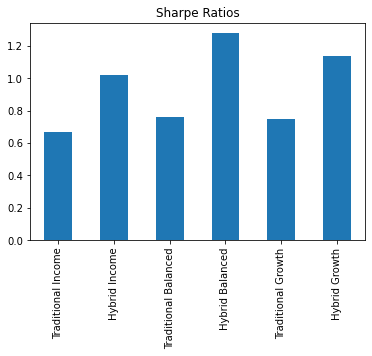

In [372]:
all_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

In [373]:
#Adding Bar Chart of Sharpe Ratios in descending order using Altair library
source = pd.DataFrame({
    'Portfolios': ['TI', 'HI', 'TB', 'HB', 'TG', 'HG'],
    'Sharpe Ratios': [all_sharpe_ratios[0], all_sharpe_ratios[1], all_sharpe_ratios[2], all_sharpe_ratios[3], all_sharpe_ratios[4], all_sharpe_ratios[5]]
})

alt.Chart(source).mark_bar().encode(
    x='Portfolios',
    y='Sharpe Ratios'
)

alt.Chart(...)

In [374]:
#Sharpe Ratio Summary Statement
print(f"For the Traditional Growth Portfolio, the Sharpe Ratio is {thg_sharpe_ratios[0]:0.2f}.")
print(f"For the Hybrid Growth Portfolio, the Sharpe Ratio is {thg_sharpe_ratios[1]:0.2f}.")

For the Traditional Growth Portfolio, the Sharpe Ratio is 0.75.
For the Hybrid Growth Portfolio, the Sharpe Ratio is 1.14.


In [375]:
# Set initial investment and assign variables
init_inv = 10000
total_ti = thi_cumulative_returns.iloc[-1:,0]*initial_inv
total_hi = thi_cumulative_returns.iloc[-1:,-1]*initial_inv
total_tb = thb_cumulative_returns.iloc[-1:,0]*initial_inv
total_hb = thb_cumulative_returns.iloc[-1:,-1]*initial_inv
total_tg = thg_cumulative_returns.iloc[-1:,0]*initial_inv
total_hg = thg_cumulative_returns.iloc[-1:,-1]*initial_inv

In [376]:
#Cumulative Summary statement
print(f"An inital investment of ${init_inv} into the Traditional Income Portfolio on 2017-04-12 would be worth ${total_ti[0]:0.2f} on 2021-03-31.")
print(f"An inital investment of ${init_inv} into the Hybrid Income Portfolio on 2017-04-12 would be worth ${total_hi[0]:0.2f} on 2021-03-31.")
print(f"An inital investment of ${init_inv} into the Traditional Balanced Portfolio on 2017-04-12 would be worth ${total_tb[0]:0.2f} on 2021-03-31.")
print(f"An inital investment of ${init_inv} into the Hybrid Balanced Portfolio on 2017-04-12 would be worth ${total_hb[0]:0.2f} on 2021-03-31.")
print(f"An inital investment of ${init_inv} into the Traditional Growth Portfolio on 2017-04-12 would be worth ${total_tg[0]:0.2f} on 2021-03-31.")
print(f"An inital investment of ${init_inv} into the Hybrid Growth on 2017-04-12 would be worth ${total_hg[0]:0.2f} on 2021-03-31.")

An inital investment of $10000 into the Traditional Income Portfolio on 2017-04-12 would be worth $11607.78 on 2021-03-31.
An inital investment of $10000 into the Hybrid Income Portfolio on 2017-04-12 would be worth $12817.08 on 2021-03-31.
An inital investment of $10000 into the Traditional Balanced Portfolio on 2017-04-12 would be worth $13531.99 on 2021-03-31.
An inital investment of $10000 into the Hybrid Balanced Portfolio on 2017-04-12 would be worth $14100.10 on 2021-03-31.
An inital investment of $10000 into the Traditional Growth Portfolio on 2017-04-12 would be worth $15523.65 on 2021-03-31.
An inital investment of $10000 into the Hybrid Growth on 2017-04-12 would be worth $20460.86 on 2021-03-31.
